In [7]:
!pip install tslearn

In [8]:
import numpy as np
from matplotlib import cm
import matplotlib.pyplot as plt
from itertools import cycle

from tslearn.neighbors import KNeighborsTimeSeriesClassifier
from tslearn.preprocessing import TimeSeriesScalerMinMax
from tslearn.datasets import UCR_UEA_datasets
from tslearn.shapelets import LearningShapelets
from tslearn.svm import TimeSeriesSVC 

from sklearn.model_selection import GridSearchCV, RepeatedStratifiedKFold
from sklearn.pipeline import Pipeline

from tensorflow.keras.optimizers import Adam

ECG5000 dataset, source:
https://timeseriesclassification.com/description.php?Dataset=ECG5000

In [9]:
#Creating training and test data
X_train, y_train, X_test, y_test = UCR_UEA_datasets().load_dataset("ECG5000")

# Normalize the time series between [0,1]
X_train = TimeSeriesScalerMinMax().fit_transform(X_train)
X_test = TimeSeriesScalerMinMax().fit_transform(X_test)
np.shape(X_train)

(500, 140, 1)

In [10]:
# I used K-Neighbors time series classifier under tslearn package.
# The data will be normalized using min-max normalization.
#Then we tune the n_neighbors and weights hyper-parameters.

cycol = cycle('bgrcmk')
n_splits=2 # Since the least populated class has 2 members
#Pipeline for cross-validation by using KNeighborsTimeSeriesClassifier and RepeatedKFold

pip_knn=Pipeline([
            ('normalize', TimeSeriesScalerMinMax()),
            ('knn', KNeighborsTimeSeriesClassifier())]
)
cv=RepeatedStratifiedKFold(n_splits=n_splits, n_repeats=10, random_state=42)

pipeline = GridSearchCV(pip_knn,
                        {'knn__n_neighbors': [1,5,10,25,50], 'knn__weights': ['uniform', 'distance']},
                        cv=cv
)

In [11]:
# Fit the pipeline to training data.
pipeline.fit(X_train, y_train)
results = pipeline.cv_results_
results

{'mean_fit_time': array([0.0361131 , 0.03576542, 0.03567333, 0.03523805, 0.03534701,
        0.03527544, 0.03575929, 0.03572662, 0.03602067, 0.03560866]),
 'mean_score_time': array([41.01072427, 40.814376  , 40.73420659, 40.66551337, 40.65438588,
        40.61211101, 40.51897146, 40.53860073, 40.52280387, 40.56443846]),
 'mean_test_score': array([0.928 , 0.928 , 0.9294, 0.9356, 0.9232, 0.9288, 0.9182, 0.9216,
        0.9158, 0.9178]),
 'param_knn__n_neighbors': masked_array(data=[1, 1, 5, 5, 10, 10, 25, 25, 50, 50],
              mask=[False, False, False, False, False, False, False, False,
                    False, False],
        fill_value='?',
             dtype=object),
 'param_knn__weights': masked_array(data=['uniform', 'distance', 'uniform', 'distance',
                    'uniform', 'distance', 'uniform', 'distance',
                    'uniform', 'distance'],
              mask=[False, False, False, False, False, False, False, False,
                    False, False],
      

Metrics and confusion matrice for K-nearest Neighbors classification

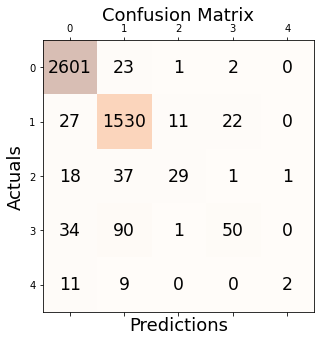

In [12]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

y_pred = pipeline.predict(X_test)
#
# Calculate the confusion matrix
#
conf_matrix = confusion_matrix(y_true=y_test, y_pred=y_pred)
#
# Print the confusion matrix using Matplotlib
#
fig, ax = plt.subplots(figsize=(5, 5))
ax.matshow(conf_matrix, cmap=plt.cm.Oranges, alpha=0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')
 
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()


In [13]:
#Hyperparameter knn metrics
print('Precision: %.3f' % precision_score(y_test, y_pred, average='weighted'))
print('Recall: %.3f' % recall_score(y_test, y_pred, average='weighted'))
print('Accuracy: %.3f' % accuracy_score(y_test, y_pred))
print('F1 Score: %.3f' % f1_score(y_test, y_pred, average='weighted'))

Precision: 0.927
Recall: 0.936
Accuracy: 0.936
F1 Score: 0.926


In [ ]:
print("K-nearest Neighbors classification rate:",pipeline.score(X_test, y_test))

K-nearest Neighbors classification rate: 0.936


Printing cross validation for 5 number of neighbors
.


In [ ]:
header_str = '|'
columns = ['n_neighbors', 'weights']
columns += ['score_fold_{}'.format(i + 1) for i in range(n_splits)]
for col in columns:
    header_str += '{:^12}|'.format(col)
print(header_str)
print('-'*(len(columns) * 13))

for i in range(len(results['params'])):
    s = '|'
    s += '{:>12}|'.format(results['params'][i]['knn__n_neighbors'])
    s += '{:>12}|'.format(results['params'][i]['knn__weights'])
    for k in range(n_splits):
        score = results['split{}_test_score'.format(k)][i]
        score = np.around(score, 5)
        s += '{:>12}|'.format(score)
    print(s.strip())

best_comb = np.argmax(results['mean_test_score'])
best_params = results['params'][best_comb]

print()
print('Best parameter combination:')
print('weights={}, n_neighbors={}'.format(best_params['knn__weights'],
                                          best_params['knn__n_neighbors']))


|n_neighbors |  weights   |score_fold_1|score_fold_2|
----------------------------------------------------
|           1|     uniform|       0.924|       0.956|
|           1|    distance|       0.924|       0.956|
|           5|     uniform|       0.936|       0.932|
|           5|    distance|        0.94|       0.952|
|          10|     uniform|        0.92|       0.932|
|          10|    distance|       0.924|       0.932|
|          25|     uniform|       0.912|       0.924|
|          25|    distance|        0.92|       0.928|
|          50|     uniform|       0.908|        0.92|
|          50|    distance|       0.908|       0.924|

Best parameter combination:
weights=distance, n_neighbors=5


<function matplotlib.pyplot.show>

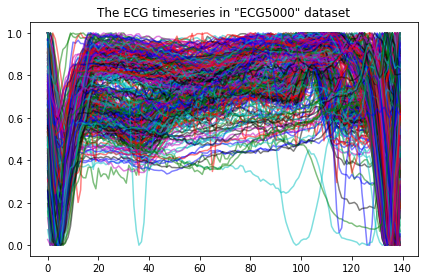

In [ ]:
# Plot ECG timeseries classified by K-nearest Neighbors method
plt.figure()
for ts, label in zip(X_train, y_train):
    plt.plot(ts,c=next(cycol), alpha=0.5)
plt.title('The ECG timeseries in "ECG5000" dataset')
plt.tight_layout()
plt.show

Global alignment kernel (GAK) for support vector classification

In [ ]:
svm_class = TimeSeriesSVC(kernel="gak", gamma=.1)
svm_class.fit(X_train, y_train)
print("SVM classification rate:", svm_class.score(X_test, y_test))

n_classes = len(set(y_train))

plt.figure()
support_vectors = svm_class.support_vectors_
for i, cl in enumerate(set(y_train)):
    plt.subplot(n_classes, 1, i + 1)
    plt.title("Support vectors for class %d" % cl)
    for ts in support_vectors[i]:
        plt.plot(ts.ravel())

plt.tight_layout()
plt.show()



In [ ]:
#Confusion matrix for Support Vector Classifier 
y_pred_svm = svm_class.predict(X_test)
#
# Calculate the confusion matrix
#
conf_matrix = confusion_matrix(y_true=y_test, y_pred=y_pred_svm)
#
# Print the confusion matrix using Matplotlib
#
fig, ax = plt.subplots(figsize=(5, 5))
ax.matshow(conf_matrix, cmap=plt.cm.Oranges, alpha=0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')
 
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()


In [ ]:
#Support Vector Machine Metrics
print('Precision: %.3f' % precision_score(y_test, y_pred_svm, average='weighted'))
print('Recall: %.3f' % recall_score(y_test, y_pred_svm, average='weighted'))
print('Accuracy: %.3f' % accuracy_score(y_test, y_pred_svm))
print('F1 Score: %.3f' % f1_score(y_test, y_pred_svm, average='weighted'))

Shapelet classification via decision boundaries in 2D distance space

In [ ]:
# Get statistics of the dataset
n_ts, ts_sz = X_train.shape[:2]
n_classes = len(set(y_train))

# We will extract 2 shapelets and align them with the time series
shapelet_sizes = {20: 2}

# Define the model and fit it using the training data
shp_class = LearningShapelets(n_shapelets_per_size=shapelet_sizes,
                            weight_regularizer=0.0001,
                            optimizer=Adam(learning_rate=0.01),
                            max_iter=300,
                            verbose=0,
                            scale=True,
                            random_state=42)
shp_class.fit(X_train, y_train)


In [ ]:
y_pred_shp = shp_class.predict(X_test)
#
# Calculate the confusion matrix
#
conf_matrix = confusion_matrix(y_true=y_test, y_pred=y_pred_shp)
#
# Print the confusion matrix using Matplotlib
#
fig, ax = plt.subplots(figsize=(5, 5))
ax.matshow(conf_matrix, cmap=plt.cm.Oranges, alpha=0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')
 
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()


In [ ]:
#shapelet transformation metrics
print('Precision: %.3f' % precision_score(y_test, y_pred_shp, average='weighted'))
print('Recall: %.3f' % recall_score(y_test, y_pred_shp, average='weighted'))
print('Accuracy: %.3f' % accuracy_score(y_test, y_pred_shp))
print('F1 Score: %.3f' % f1_score(y_test, y_pred_shp, average='weighted'))

In [ ]:
print("Shapelet classification rate:",shp_class.score(X_test, y_test))


In [ ]:
# We will plot our distances in a 2D space
distances = shp_class.transform(X_train).reshape((-1, 2))
weights, biases = shp_class.get_weights('classification')

In [ ]:
# Create a grid for our two shapelets on the left and distances on the right
viridis = cm.get_cmap('viridis', 5)
fig = plt.figure(constrained_layout=True)
gs = fig.add_gridspec(3, 9)
fig_ax1 = fig.add_subplot(gs[0,0])
fig_ax2 = fig.add_subplot(gs[0,1])
fig_ax3b = fig.add_subplot(gs[1, :2])
fig_ax3c = fig.add_subplot(gs[1, 2:4])
fig_ax3d = fig.add_subplot(gs[2, :2])
fig_ax3e = fig.add_subplot(gs[2, 2:4])
fig_ax3a = fig.add_subplot(gs[0, 2:4])
fig_ax4 = fig.add_subplot(gs[:, 4:])

# Plot our two shapelets on the left side
fig_ax1.plot(shp_class.shapelets_[0])
fig_ax1.set_title('Shapelet $\mathbf{s}_1$')

fig_ax2.plot(shp_class.shapelets_[1])
fig_ax2.set_title('Shapelet $\mathbf{s}_2$')

# Create the time series of each class
for i, subfig in enumerate([fig_ax3a, fig_ax3b, fig_ax3c, fig_ax3d, fig_ax3e]):
    for k, ts in enumerate(X_train[y_train == i + 1]):
        subfig.plot(ts.flatten(), c=viridis(i), alpha=0.25)
        subfig.set_title('Class {}'.format(i + 1))
fig.text(x=.15, y=.02, s='Input time series', fontsize=12)

# Create a scatter plot of the 2D distances for the time series of each class.
for i, y in enumerate(np.unique(y_train)):
    fig_ax4.scatter(distances[y_train == y][:, 0],
                    distances[y_train == y][:, 1],
                    c=[viridis(i)] * np.sum(y_train == y),
                    edgecolors='k',
                    label='Class {}'.format(y))
    
# Create a meshgrid of the decision boundaries
xmin = np.min(distances[:, 0]) - 0.1
xmax = np.max(distances[:, 0]) + 0.1
ymin = np.min(distances[:, 1]) - 0.1
ymax = np.max(distances[:, 1]) + 0.1
xx, yy = np.meshgrid(np.arange(xmin, xmax, (xmax - xmin)/200),
                        np.arange(ymin, ymax, (ymax - ymin)/200))

Z = []
for x, y in np.c_[xx.ravel(), yy.ravel()]:
    Z.append(np.argmax([biases[i] + weights[0][i]*x + weights[1][i]*y
                           for i in range(5)]))
Z = np.array(Z).reshape(xx.shape)
cs = fig_ax4.contourf(xx, yy, Z / 3, cmap=viridis, alpha=0.25)

fig_ax4.legend()
fig_ax4.set_xlabel('$d(\mathbf{x}, \mathbf{s}_1)$')
fig_ax4.set_ylabel('$d(\mathbf{x}, \mathbf{s}_2)$')
fig_ax4.set_xlim((xmin, xmax))
fig_ax4.set_ylim((ymin, ymax))
fig_ax4.set_title('Distance transformed time series')
plt.show()